## Import CSV Data into Pandas DataFrame

- Historical Dataset -> Dataset from 2012 to 2024
- 2024 Dataset with more information about the single year

In [10]:
# Imports
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt


# Files config
CSV_HISTORICO = 'datasets/inv-superficie-viniedos-2012-2024.csv'
CSV_TYPES_2024 =  'datasets/inv-superficie-id-2024.CSV'
SQLITE_DB = 'vinedos_argentina.db'

# Read CSV
try:
    df_historico = pd.read_csv(CSV_HISTORICO)
except FileNotFoundError:
    print(f"Error: El archivo {CSV_HISTORICO} no se encontró.")
    df_historico = pd.DataFrame()  # Empty DataFrame in case of Error

try:
    df_2024 = pd.read_csv(CSV_TYPES_2024)
except FileNotFoundError:
    print(f"Error: El archivo {CSV_TYPES_2024} no se encontró.")
    df_2024 = pd.DataFrame()  # Empty DataFrame in case of Error
    

## Data Cleaning
The Data was pre-cleaning in google sheets.
- Check for nulls and eliminate them
- Check for data types
- Check for duplicates and eliminate them


In [46]:
df_historico.info()
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9053 entries, 0 to 9052
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anio                 9053 non-null   int64  
 1   provincia_id         9053 non-null   int64  
 2   provincia_nombre     9053 non-null   object 
 3   departamento_id      9053 non-null   int64  
 4   departamento_nombre  9053 non-null   object 
 5   localidad_id         9053 non-null   object 
 6   localidad_nombre     9053 non-null   object 
 7   superficie_ha        9053 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 565.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88306 entries, 0 to 88305
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anio                 88306 non-null  int64  
 1   provincia_id         88306 non-null  int64  
 2   provincia_nombre

In [58]:
df_historico.describe()

,anio,provincia_id,departamento_id,superficie_ha
count,9053.000000,9053.000000,9053.000000,9053.000000
mean,2018.189330,49.079642,49160.031592,310.594126
std,3.735119,19.506312,19477.901421,706.524312
min,2012.000000,6.000000,6035.000000,0.006000
25%,2015.000000,46.000000,46049.000000,4.570000
50%,2018.000000,50.000000,50091.000000,33.818000
75%,2021.000000,66.000000,66014.000000,232.450000
max,2024.000000,90.000000,90112.000000,7076.920000


In [59]:
df_2024.describe()

,anio,provincia_id,departamento_id,anio_plantacion,superficie_plantada
count,88306.0,88306.000000,88306.000000,88306.000000,88306.000000
mean,2024.0,52.495685,52574.023226,1989.774545,2.264239
std,0.0,11.543690,11536.907408,22.950339,3.726182
min,2024.0,6.000000,6035.000000,1862.000000,0.000000
25%,2024.0,50.000000,50056.000000,1972.000000,0.500000
50%,2024.0,50.000000,50098.000000,1998.000000,1.210000
75%,2024.0,50.000000,50119.000000,2008.000000,2.600000
max,2024.0,90.000000,90112.000000,2024.000000,123.200000


## Check for planted_area distribution in both datasets

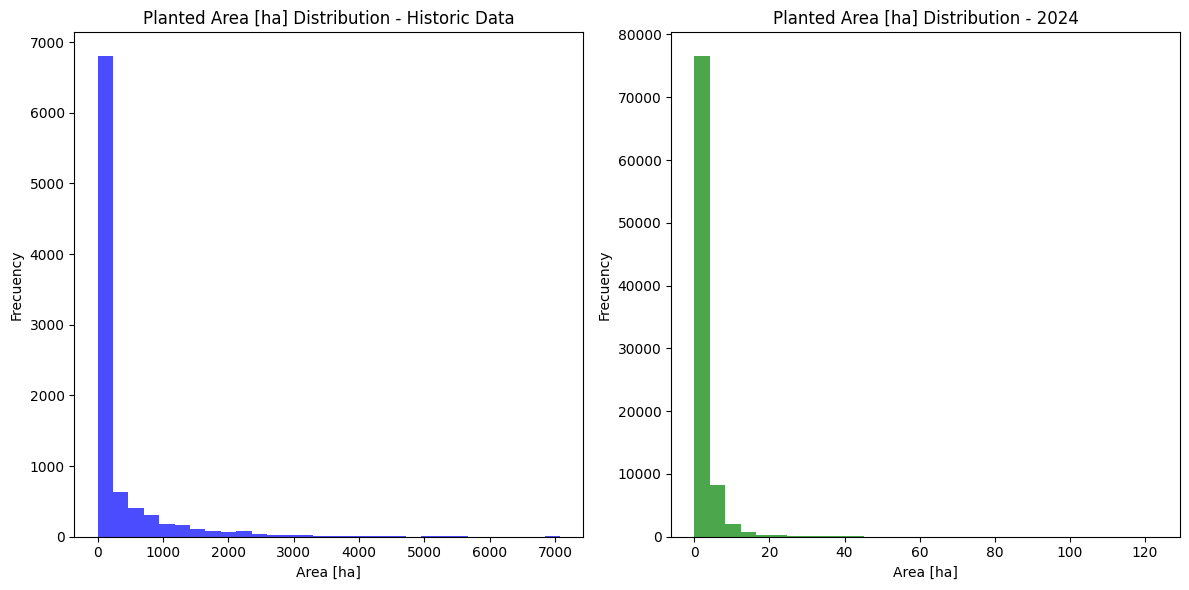

In [70]:
# Distribution of superficie_ha in df_historico and df_2024
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_historico['superficie_ha'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Planted Area [ha] Distribution - Historic Data')
plt.xlabel('Area [ha]')
plt.ylabel('Frecuency')
plt.subplot(1, 2, 2)
plt.hist(df_2024['superficie_plantada'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Planted Area [ha] Distribution - 2024')
plt.xlabel('Area [ha]')
plt.ylabel('Frecuency')
plt.tight_layout()
plt.show()



## Save into a SQLite Database

In [71]:
# Save into a SQLite database
conn = sqlite3.connect(SQLITE_DB)
df_historico.to_sql('historico_vinedos', conn, if_exists='replace', index=False)
df_2024.to_sql('vineyards_2024',conn, if_exists='replace', index=False)
conn.close()


## Queries to analyze data

### Provinces by years

The first query aims to get a dataframe with the historical planted area for each province.
Then, you can select one of those provinces and plot the evolution through the time

In [ ]:
# Query for all provinces

try:
    # Connect to the database
    conn = sqlite3.connect(SQLITE_DB)
    query = """
        SELECT  anio AS year,
                provincia_nombre AS province,
                SUM(superficie_ha) AS total_area_ha
        FROM historico_vinedos
        GROUP BY anio, provincia_nombre
        HAVING total_area_ha > 0
    """
    # Save the query result into a DataFrame
    df_provincias_historico = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()


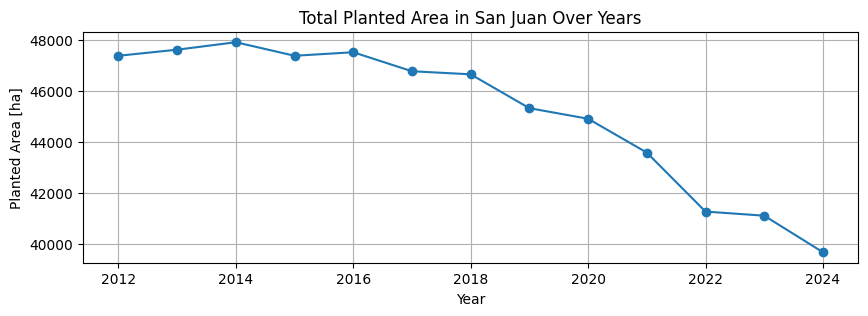

In [83]:
search_province = 'San Juan'
df_provin = df_provincias_historico[df_provincias_historico['province'] == search_province]
plt.figure(figsize=(10, 3))
plt.plot(df_provin['year'], df_provin['total_area_ha'], marker='o')
plt.title(f'Total Planted Area in {search_province} Over Years')
plt.xlabel('Year')
plt.ylabel('Planted Area [ha]')
plt.grid()
plt.show()

## General information about the 2024 dataset

In [ ]:
# First look into the 2024 dataset

try:
    # Connect to database
    conn = sqlite3.connect(SQLITE_DB)
    query = """
        SELECT provincia_nombre as province, 
                departamento_nombre as department, 
                localidad_nombre as locality, 
                variedad as variety, 
                color, 
                anio_plantacion as year_of_plantation, 
                superficie_plantada as planted_area_ha
        FROM vineyards_2024
    """
    df_2024_query = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()

df_2024_query.head()

,province,department,locality,variety,color,year_of_plantation,planted_area_ha
0,Buenos Aires,Avellaneda,Sarandí,Isabella,tinta,1896,1.0341
1,Buenos Aires,Avellaneda,Villa Domínico,Isabella,tinta,1956,0.7365
2,Buenos Aires,Avellaneda,Villa Domínico,Isabella,tinta,1970,2.0000
3,Buenos Aires,Balcarce,Balcarce,Chardonnay,blanca,2013,0.6600
4,Buenos Aires,Balcarce,Balcarce,Sauvignon Blanc,blanca,2021,0.0704


2024 Vineyard Dataset Analysis
Total unique varieties in 2024 dataset: 186
Unique colors in 2024 dataset: ['tinta' 'blanca' 'rosada']
Top 3 locations with most vineyards in 2024 dataset:
locality
Montecaseros       2809
Chapanay           2140
Costa de Araujo    2003
Name: count, dtype: int64
Top 3 locations with highest planted area in 2024 dataset:
        province      locality             variety  color  planted_area_ha
599    Catamarca  Chañar Punco  Cabernet Sauvignon  tinta         123.2000
23710    Mendoza        Agrelo              Malbec  tinta         112.3952
84671   San Juan    San Carlos              Malbec  tinta         100.0000
------------------------------------------------------------------


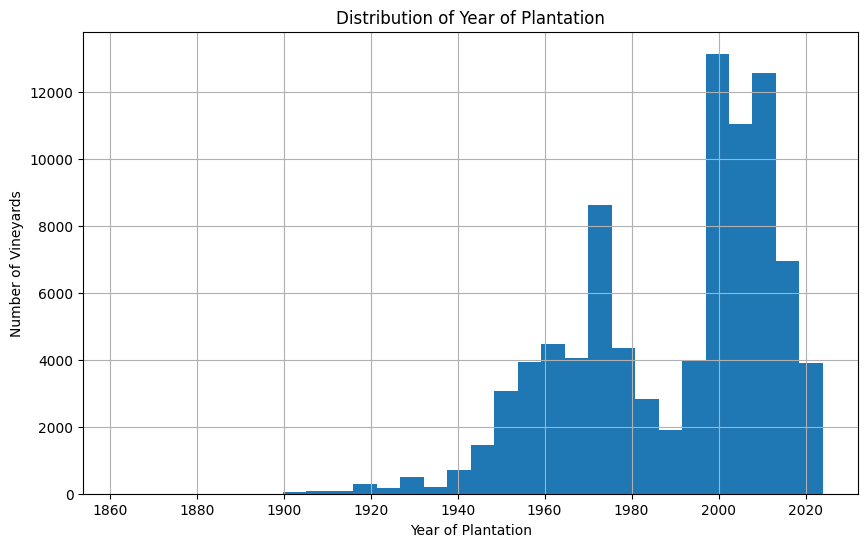

In [90]:
# Simple Analysis from Dataframe query
Total_varieties = df_2024_query['variety'].nunique()
Color_2024 = df_2024_query['color'].unique()
top3_locations = df_2024_query['locality'].value_counts().head(3)
top3_planted_area = df_2024_query.sort_values(by='planted_area_ha', ascending=False).head(3)[['province','locality', 'variety','color','planted_area_ha']]

print('2024 Vineyard Dataset Analysis')
print(f'Total unique varieties in 2024 dataset: {Total_varieties}')
print(f'Unique colors in 2024 dataset: {Color_2024}')
print('Top 3 locations with most vineyards in 2024 dataset:')
print(top3_locations)
print("Top 3 locations with highest planted area in 2024 dataset:")
print(top3_planted_area)
print("------------------------------------------------------------------")


# Year of Plantation Distribution
plt.figure(figsize=(10,6))
df_2024_query['year_of_plantation'].dropna().astype(int).hist(bins=30)
plt.title('Distribution of Year of Plantation')
plt.xlabel('Year of Plantation')
plt.ylabel('Number of Vineyards')
plt.show()
